

# Lecture 16: Quantum teleportation and simple QPE

In [1]:
# Import usual python numerical library
import numpy as np
# Importing standard Qiskit libraries
from qiskit import *

%matplotlib inline

In [2]:
import subprocess

#this is so I can run the code on my computer without sharing my token online
#you can get your own token at https://quantum-computing.ibm.com/account
token = subprocess.run("echo $IBM_TOKEN", shell=True, stdout=subprocess.PIPE).stdout.decode('utf-8').strip()
# for the bots out there, I invalitdated the toke I accedentally shared

In [3]:
# Insert your token
from qiskit_ibm_runtime import QiskitRuntimeService
 
QiskitRuntimeService.save_account(
  token=token,channel="ibm_quantum", # `channel` distinguishes between different account types
  overwrite=True, set_as_default=True)

In [4]:
# Find backends available AND currently operational through IBMQ and print 
# the number of pending jobs to see how busy they are:

service = QiskitRuntimeService(channel="ibm_quantum")

for backend in service.backends(operational = True):    
    print(backend.name, ', n_qubits =', backend.configuration().n_qubits, 
          ', pending_jobs =', backend.status().pending_jobs)
    

ibm_brisbane , n_qubits = 127 , pending_jobs = 2
ibm_kyiv , n_qubits = 127 , pending_jobs = 9
ibm_sherbrooke , n_qubits = 127 , pending_jobs = 3


In [5]:

from qiskit_aer import AerSimulator



In [6]:
# This sets a simulator and a real device for you to work with. Feel free to choose a different real device by 
# checking if it's less busy.
backend_simulator = AerSimulator()
backend_brisbane = service.backend("ibm_brisbane")


In [7]:
# Display the native gates in the real backends. All circuits you submit will have to be transpiled to these native gates, that's why 
# the transpiled circuits are so large
print(backend_brisbane.configuration().supported_instructions)


['ecr', 'id', 'delay', 'measure', 'reset', 'rz', 'sx', 'x', 'if_else', 'for_loop', 'switch_case']


# Quantum teleportation



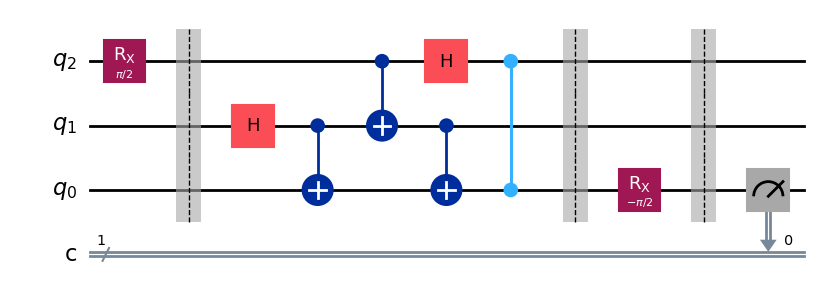

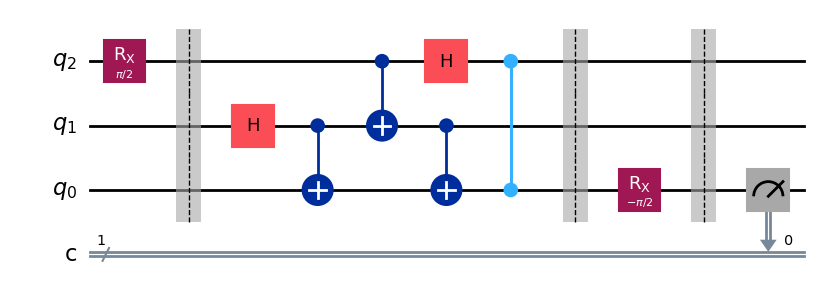

In [8]:
# let's teleport our favourite state.
# Define circuit with 3 qubits, 1 cbits
circ_tel = QuantumCircuit(3, 1)
# Making my favourite state in qubit 2
th=np.pi/2
circ_tel.rx(th,2) # this is Unitary U
circ_tel.barrier(range(3))
# Code quantum teleportation algorithm below

circ_tel.h(1)
circ_tel.cx(1,0)
circ_tel.cx(2,1)

circ_tel.h(2)
circ_tel.cx(1,0)

circ_tel.cz(2, 0)
# End of quantum teleportation algorithm

circ_tel.barrier(range(3))

#apply U^dagger on qubit 0
circ_tel.rx(-th,0)

#
circ_tel.barrier(range(3))
circ_tel.measure(0,0) # read out qubit 0, and load it in classical bit 0.
#
circ_tel.draw(reverse_bits=True, output="mpl")


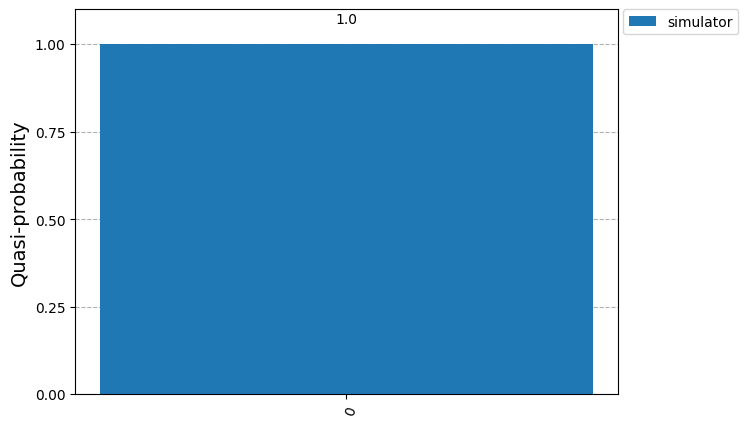

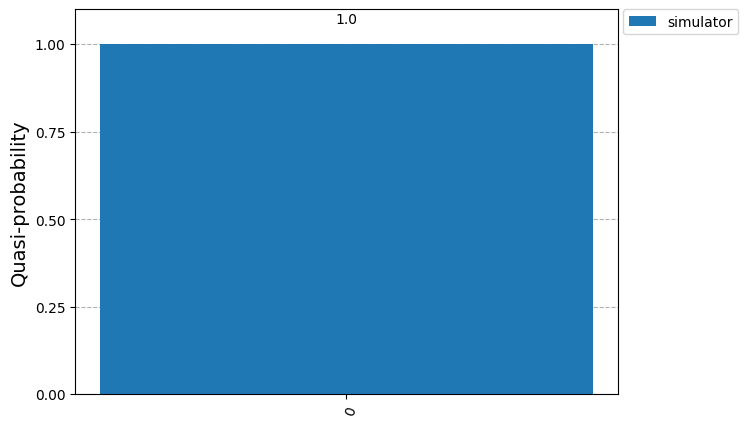

In [9]:
# Run in the simulator
job_simulator = backend_simulator.run(circ_tel, shots=10000)
from qiskit.visualization import *
result_simulator = job_simulator.result()

counts_simulator = result_simulator.get_counts(circ_tel)
plot_distribution([counts_simulator], legend=['simulator'])


# How can we check that we have the correct state?



# Quantum Phase estimation


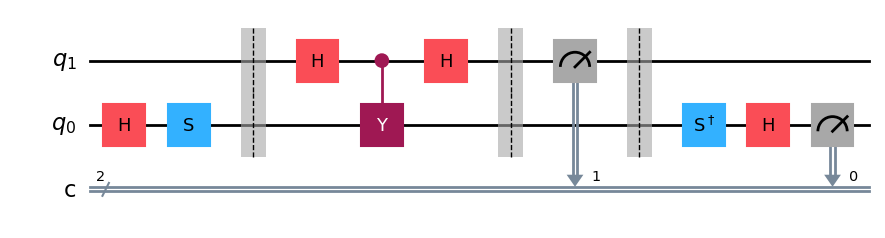

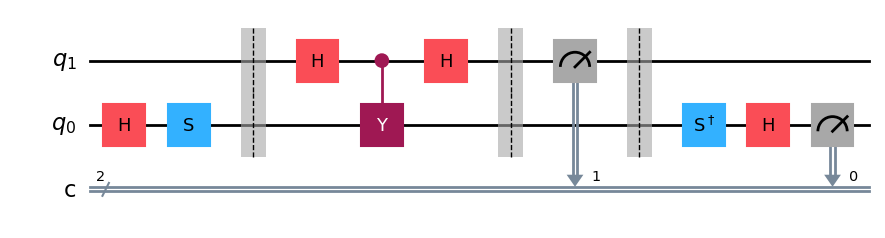

In [11]:
# circuit with |+i> input
circ_qpe = QuantumCircuit(2, 2)
# prepare |+i> state:
circ_qpe.h(0)
circ_qpe.s(0)
circ_qpe.barrier(range(2))
# circuit:
circ_qpe.h(1)
circ_qpe.cy(1,0)
circ_qpe.h(1)
#
circ_qpe.barrier(range(2))
circ_qpe.measure(1,1)
# This finishes the circuit. Now let's add a unitary that takes |+i> into |0>, and measure:
circ_qpe.barrier(range(2))
circ_qpe.sdg(0)
circ_qpe.h(0)
circ_qpe.measure(0,0)
#
circ_qpe.draw(reverse_bits=True, output="mpl")



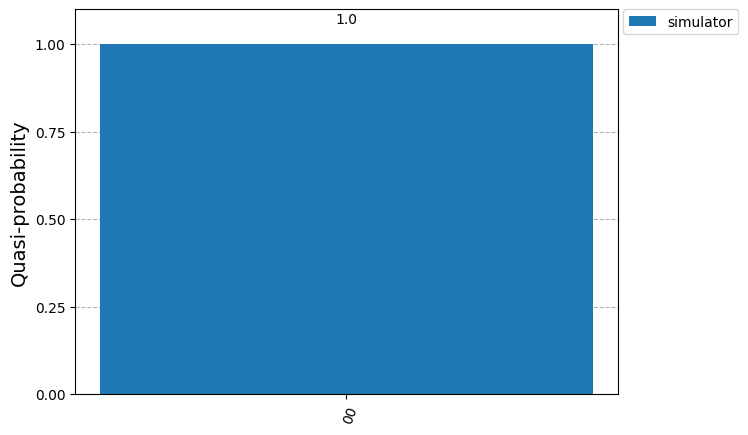

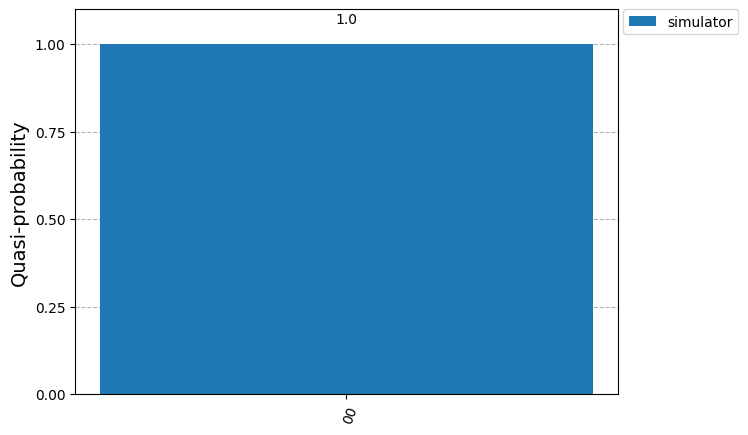

In [ ]:
# Execute on local simulator for input with |+i>

job_simulator = backend_simulator.run(circ_qpe, shots=10000)
result_simulator = job_simulator.result()

counts_simulator = result_simulator.get_counts(circ_qpe)
plot_distribution([counts_simulator], legend=['simulator'])


In [ ]:
# Submit job to real device. Remember we have to transpile first

transpiled_circ_tel = transpile(circ_tel, backend=backend_brisbane)

pm = generate_preset_pass_manager(backend=backend_brisbane, optimization_level=1)
isa_circ_qpe = pm.run(transpiled_circ_tel)
from qiskit_ibm_runtime import SamplerV2
sampler = SamplerV2(backend_brisbane)
job_brisbane1 = sampler.run([isa_circ_qpe])


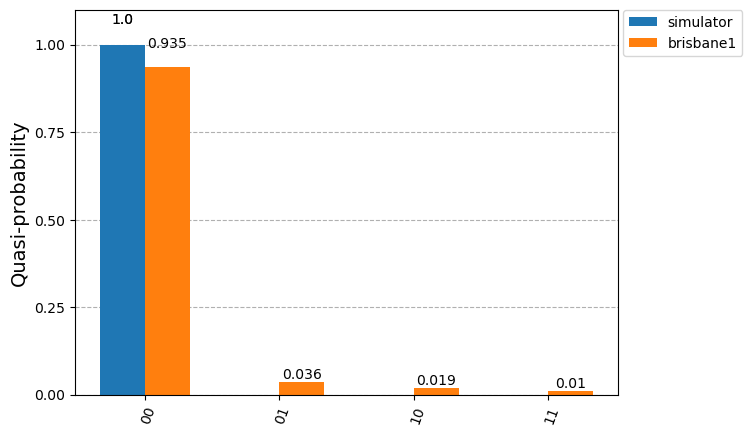

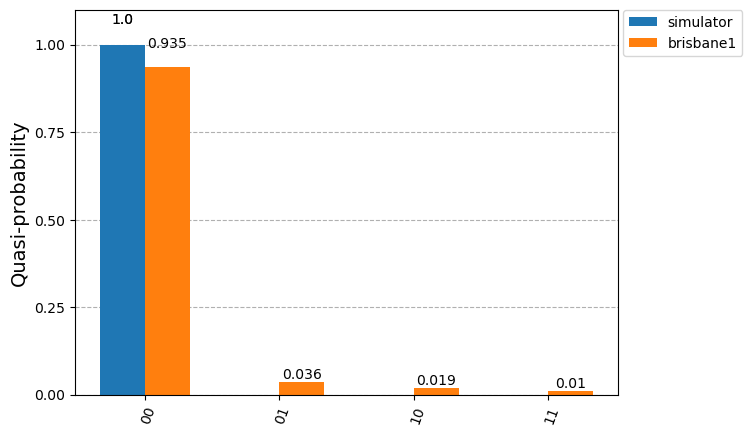

In [ ]:
# Load and plot the results
counts_brisbane1 = job_brisbane1.result()[0].data.c.get_counts()
plot_distribution([counts_simulator, counts_brisbane1], legend = ['simulator', 'brisbane1'] )


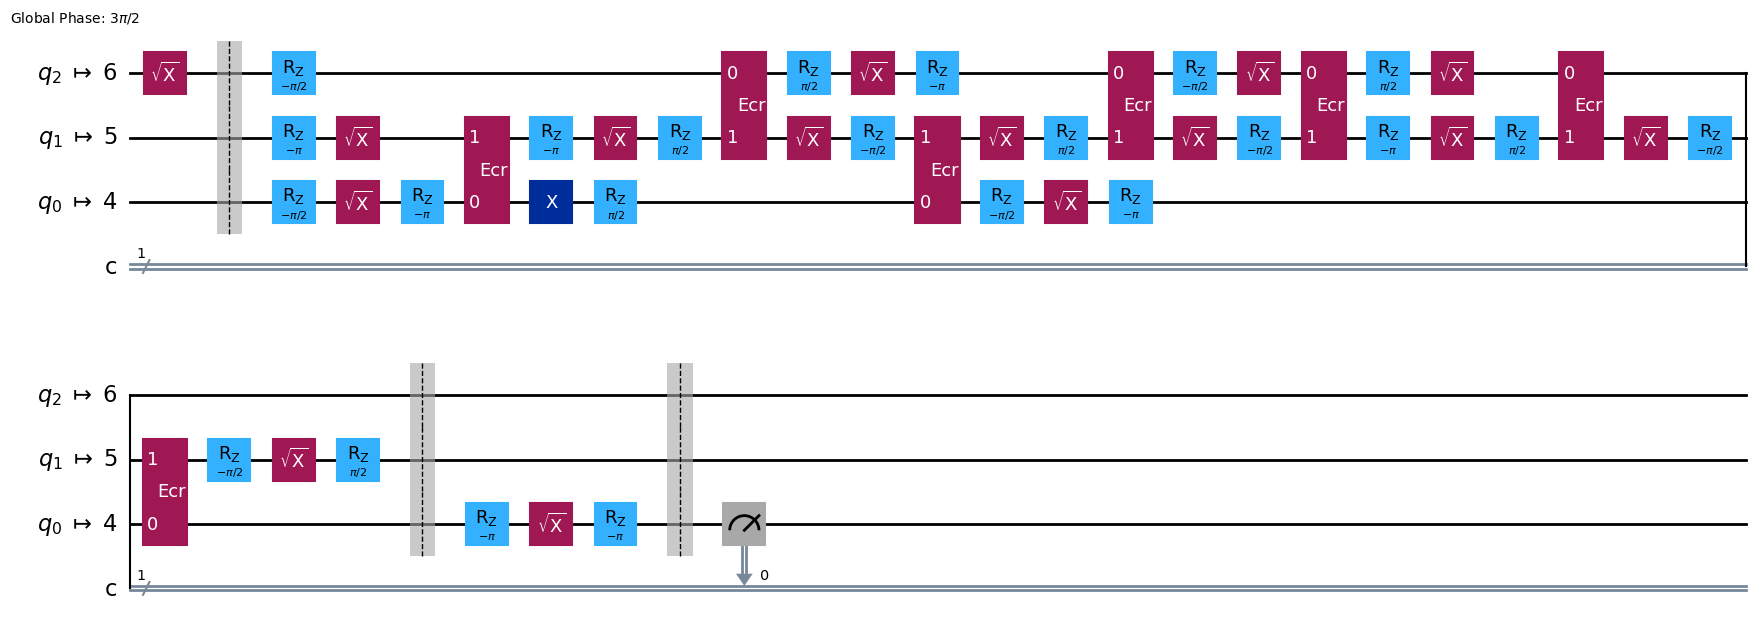

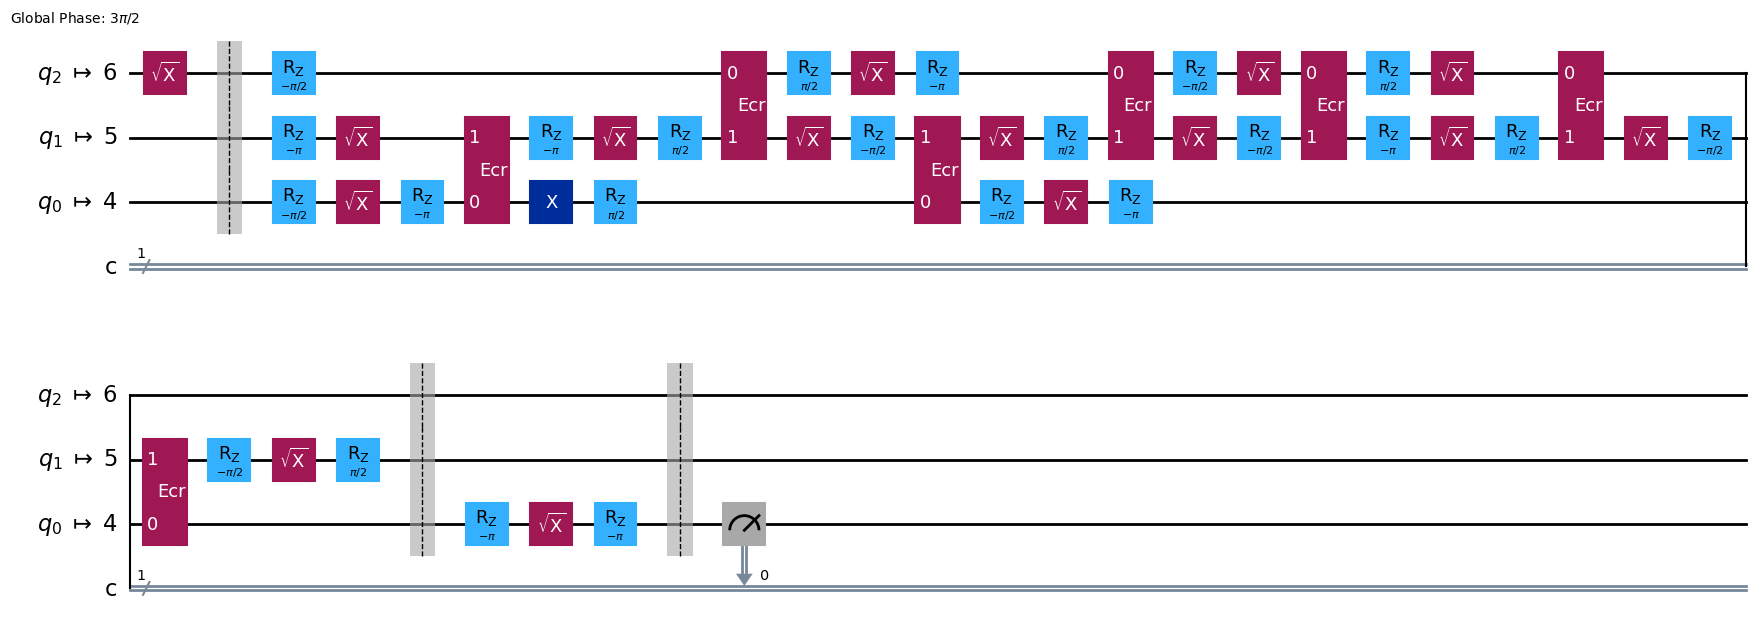

In [ ]:
# Why the error? Check out the transpiled circuit


isa_circ_qpe.draw(reverse_bits=True, idle_wires=False, output="mpl")